# This notebook covers the following topics: 

- Feature engineering
- Estimate baseline model(i.e. KNN) and evaluate model performance
- Estimate different model(i.e. RF) and compare its performance w/ baseline model
- Interpretaion/Summary

### Reiterate our incentives: 

By building a model to improve the Zestimate residual error, we will help millions of American household make accurate estimation on their home value. The resulting model will better the current Zestimate system and help the company with targeting their ads and service, boosting the overal revenue. 

Since both the estimation price and the actual selling price are confidential, our most important feature is provided by the Zillow dataset, which is the log-error between their Estimate price and the actual sale price. It is defined as: logerror=log(Zestimate)−log(SalePrice)

## 1, Load libraries and import data

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score

%matplotlib inline

In [2]:
train = pd.read_csv('train_2016_v2.csv', parse_dates=['transactiondate'])
train.shape

(90275, 3)

In [3]:
prop = pd.read_csv('properties_2016.csv')
prop.shape

/Users/user/opt/anaconda3/envs/env-stats404-w20/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2985217, 58)

In [4]:
prop.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


## 2, Deciding on the feature variables

In [5]:
prop.columns

Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildin

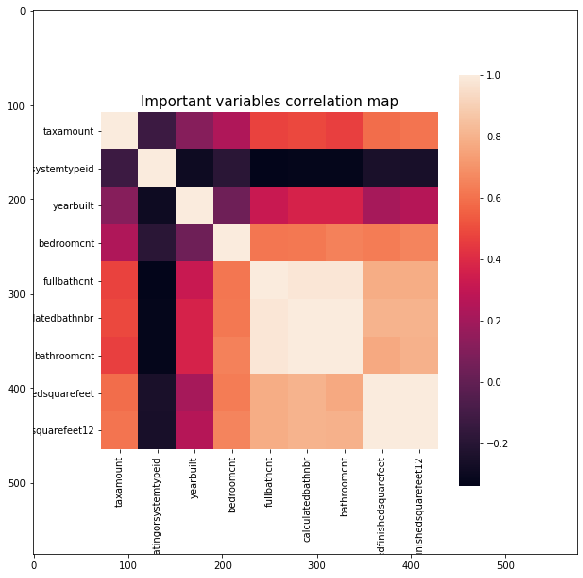

In [6]:
img = mpimg.imread('figure.png')
plt.figure(figsize=(10,10))
plt.imshow(img)

### According to this heating map from HW2, I've decided to use 'taxamount', 'yearbuilt', 'bedroomcnt', 'bathroomcnt', 'heatingorsystemtypeid', 'calculatedfinishedsquarefeet' as key features, and drop the rest of the columns. 

In [7]:
X = prop[['parcelid', 'taxamount','yearbuilt','bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
X.head()

,parcelid,taxamount,yearbuilt,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet
0,10754147,NaN,NaN,0.0,0.0,NaN
1,10759547,NaN,NaN,0.0,0.0,NaN
2,10843547,20800.37,NaN,0.0,0.0,73026.0
3,10859147,14557.57,1948.0,0.0,0.0,5068.0
4,10879947,5725.17,1947.0,0.0,0.0,1776.0


## 3, Remove NaNs/0s and merge X with train

In [8]:
X = X.dropna()
X = X[(X.bathroomcnt > 0) & (X.bedroomcnt > 0) & (X.calculatedfinishedsquarefeet > 0)]
X.shape

(2843162, 6)

In [9]:
X.head()

,parcelid,taxamount,yearbuilt,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet
19,11324547,6941.39,2005.0,2.0,4.0,3633.0
26,11488147,10455.41,1972.0,4.0,5.0,2865.0
28,11524947,6165.36,2004.0,2.0,2.0,1090.0
29,11544747,10244.94,2011.0,4.0,3.0,1620.0
31,11585547,7924.68,1926.0,2.0,3.0,2077.0


In [10]:
X = pd.merge(X, train, on='parcelid')#Merge X and train
X.shape

(88735, 8)

## 4, Sorting

In [11]:
X.sort_values(by=['parcelid', 'transactiondate'], inplace=True)
X.head()

,parcelid,taxamount,yearbuilt,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,logerror,transactiondate
61013,10711738,7219.18,1978.0,3.0,4.0,2538.0,0.0276,2016-08-02
81581,10711755,6901.09,1959.0,3.0,3.0,1589.0,-0.0182,2016-08-02
4319,10711805,4876.61,1973.0,2.0,3.0,2411.0,-0.1009,2016-05-03
12360,10711816,5560.07,1973.0,2.0,4.0,2232.0,-0.0121,2016-04-05
82881,10711858,4878.25,1973.0,2.0,4.0,1882.0,-0.0481,2016-07-15


## 5, Adding new feature transaction_yearmonth(2016) to our df for computing distance measurement.

In [12]:
#X['transaction_year'] = X['transactiondate'].dt.year
#X['transaction_month'] = X['transactiondate'].dt.month
X['transaction_yearmonth'] = 100 * X['transactiondate'].dt.year + X['transactiondate'].dt.month
X.head()

,parcelid,taxamount,yearbuilt,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,logerror,transactiondate,transaction_yearmonth
61013,10711738,7219.18,1978.0,3.0,4.0,2538.0,0.0276,2016-08-02,201608
81581,10711755,6901.09,1959.0,3.0,3.0,1589.0,-0.0182,2016-08-02,201608
4319,10711805,4876.61,1973.0,2.0,3.0,2411.0,-0.1009,2016-05-03,201605
12360,10711816,5560.07,1973.0,2.0,4.0,2232.0,-0.0121,2016-04-05,201604
82881,10711858,4878.25,1973.0,2.0,4.0,1882.0,-0.0481,2016-07-15,201607


In [13]:
min_transaction_yearmonth = X.transaction_yearmonth.min()
X['transaction_yearmonth_i'] = X.transaction_yearmonth - min_transaction_yearmonth
np.sort(X.transaction_yearmonth_i.unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

## 6, Estimate a baseline model(KNN)

In [14]:
y = X.logerror
X = X[['bathroomcnt', 'bedroomcnt', 'taxamount', 'yearbuilt', 'calculatedfinishedsquarefeet', 'transaction_yearmonth_i']]
print ("X shape =", X.shape)
print ("y shape =", y.shape)
X.head()

X shape = (88735, 6)
y shape = (88735,)


,bathroomcnt,bedroomcnt,taxamount,yearbuilt,calculatedfinishedsquarefeet,transaction_yearmonth_i
61013,3.0,4.0,7219.18,1978.0,2538.0,7
81581,3.0,3.0,6901.09,1959.0,1589.0,7
4319,2.0,3.0,4876.61,1973.0,2411.0,4
12360,2.0,4.0,5560.07,1973.0,2232.0,3
82881,2.0,4.0,4878.25,1973.0,1882.0,6


## Fit nearest neighbors regression

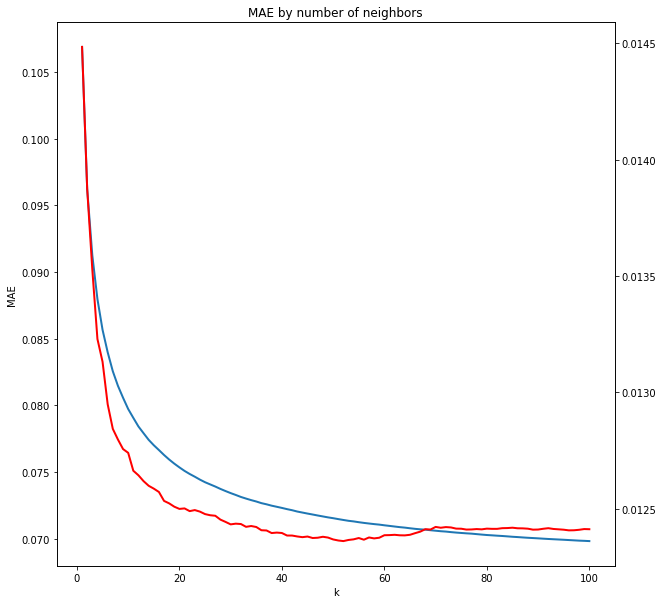

In [15]:
n_neighbors_lst = np.arange(1, 100+1, 1)
mae_lst = []
std_lst = []

for n_neighbors in n_neighbors_lst: 
    #n_neighbors = 5
    weights = 'distance'
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    scores = cross_val_score(knn, X, y, scoring='neg_mean_absolute_error', cv=5)
    scores = np.fabs(scores)
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    mae_lst.append(mean_score)
    std_lst.append(std_score)
#knn.fit(X, y)
#y_hat = knn.predict(X)

#mae = np.mean(np.fabs(y - y_hat))
#mae_lst.append(mae)

plt.figure(figsize=(10,10))
plt.plot(n_neighbors_lst, mae_lst, linewidth=2)
plt.title('MAE by number of neighbors')
plt.xlabel('k')
plt.ylabel('MAE')

plt2 = plt.twinx()
plt2.plot(n_neighbors_lst, std_lst, linewidth=2, color='red')

## 7, Fit another model(i.e. RandomForestRegressor) and compare

In [19]:
parameters = {'n_estimators':[50,75,100],'n_jobs':[-1],'oob_score':[False]}  # this can be extended
model = RandomForestRegressor()
grid = GridSearchCV(model,param_grid=parameters,scoring='neg_mean_absolute_error',cv=3)  
grid.fit(X,y)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

## Evaluate

  param_n_estimators  mean_test_score  std_test_score
0                 50        -0.077672        0.010800
1                 75        -0.076907        0.010667
2                100        -0.076300        0.010733


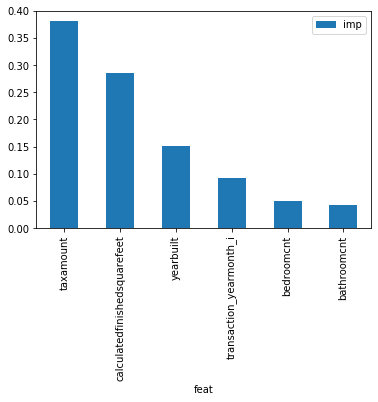

In [21]:
cv_results = pd.DataFrame(grid.cv_results_)
print(cv_results[["param_n_estimators","mean_test_score","std_test_score"]])

feat_imps = grid.best_estimator_.feature_importances_
fi = pd.DataFrame.from_dict({'feat':X.columns,'imp':feat_imps})
fi.set_index('feat',inplace=True,drop=True)
fi = fi.sort_values('imp',ascending=False)
fi.plot.bar()

In [27]:
grid.score(X,y)

-0.028447182892225916

## Summary
### Using 5 fold CV, the KNN Regressor shows improvement as we add more neighbors, both mae and std dropped significantly when K increases(i.e. plot in section 6), which make sense in real world. The more nearby homes' feature we include in our research, the more accurate our estimation of the target home's value will be. Some out-of-sample Data will be studied in the next assignment so that we can tell if it is overfitting.

### When applying RandomForestRegressor, with more than 50 estimators, it scores around 0.077(i.e. plot and table in section 7). In our home-evaluation case this looks rather abstractive. I also tried several amounts for estimators, from 5/10/15 all the way to 50/75/100. However, the score did not improve that much. 

### Since my project is not really a classification driven one, I believe KNN will do a better job. It is not only robust to the noisy training data, but is effective in case of large number of training examples.